# DQNs on GCP

Reinforcement Learning (RL) Agents can be quite fickle. This is because the environment for an Agent is different than that of Supervised and Unsupervised algorithms.

| Supervised / Unsupervised | Reinforcement Learning |
| ----------- | ----------- |
| Data is previously gathered | Data needs to be simulated |
| Big Data: Many examples covering many siutations | Sparse Data: Agent trades off between exploring and exploiting | 
| The environment is assumed static | The environment may change in response to the agent |

Because of this, hyperparameter tuning is even more crucial in RL as it not only impacts the training of the agent's neural network, but it also impacts how the data is gathered through simulation.

## Setup

Hypertuning takes some time, and in this case, it can take anywhere between **10 - 30 minutes**. If this hasn't been done already, run the cell below to kick off the training job now. We'll step through what the code is doing while our agents learn.

The above command sends a [hyperparameter tuning job](https://cloud.google.com/ml-engine/docs/hyperparameter-tuning-overview) to the [Google Cloud AI Platform](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training). It's a service that sets up scaling distributed training so data scientists and machine learning engineers do not have to worry about technical infrastructure. Usually, it automatically selects the [container environment](https://cloud.google.com/ml-engine/docs/runtime-version-list), but we're going to take advantage of a feature to specify our own environment with [Docker](https://www.docker.com/resources/what-container). Not only will this allow us to install our game environment to be deployed to the cloud, but it will also significantly speed up hyperparameter tuning time as each worker can skip the library installation steps.

The <a href="Dockerfile">Dockerfile</a> in this directory shows the steps taken to build this environment. First, we copy from a [Google Deep Learning Container](https://cloud.google.com/ai-platform/deep-learning-containers/docs/choosing-container) which already has Google Cloud Libraries installed. Then, we install our other desired modules and libraries. `ffmpeg`, `xvfb`, and `python-opengl` are needed in order to get video output from the server. Machines on the cloud don't typically have a display (why would they need one?), so we'll make a virtual display of our own.

After we copy our code, we tell the container to be configured as an executable so we can pass our hyperparameter tuning flags to it with the [ENTRYPOINT](https://stackoverflow.com/questions/21553353/what-is-the-difference-between-cmd-and-entrypoint-in-a-dockerfile) command. In order to set up our virtual display, we can use the [xvfb-run](http://manpages.ubuntu.com/manpages/trusty/man1/xvfb-run.1.html) command. Unfortunately, Docker strips quotes from specified commands in ENTRYPOINT, so we'll make a super simple shell script, <a href="train_model.sh">train_model.sh</a>, to specify our virtual display parameters. The `"@"` parameter is used to pass the flags called against the container to our python module, `trainer.trainer`.

## CartPole-v0

So what is the game we'll be solving for? We'll be playing with [AI Gym's CartPole Environment](https://gym.openai.com/envs/CartPole-v1/). As MNIST is the "Hello World" of image classification, CartPole is the "Hello World" of Deep Q Networks. Let's install [OpenAI Gym](https://gym.openai.com/) and play with the game ourselves!

In [ ]:
# !python3 -m pip freeze | grep gym || python3 -m pip install --user gym==0.26.2
# !python3 -m pip freeze | grep 'tensorflow==2.5\|tensorflow-gpu==2.1' || \
# !python3 -m pip install -U tensorflow==2.3.0
# !python3 -m pip install pygame

##### Note: Restart the kernel if the above libraries needed to be installed. Please ignore incompatibility errors.

The `gym` library hosts a number of different gaming environments that our agents (and us humans) can play around in. To make an environment, we simply need to pass it what game we'd like to play with the `make` method.

This will create an environment object with a number of useful methods and properties.
* The `observation_space` parameter is the structure of observations about the environment.
  - Each "state" or snapshot or our environment will follow this structure
* The `action_space` parameter is the possible actions the agent can take

So for example, with CartPole, there are 4 observation dimensions which represent `[Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip]`. For the actions, there are 2 possible actions to take: 0 pushes the cart to the left, and 1 pushes the cart to the right. More detail is described in the game's code [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).

In [ ]:
from collections import deque

import gymnasium as gym
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
import datetime
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')
print("The observation space is", env.observation_space)
print("The observation dimensions are", env.observation_space.shape)
print("The action space is", env.action_space)
print("The number of possible actions is", env.action_space.n)

* The `reset` method will restart the environment and return a starting state.
* The `step` method takes an action, applies it to the environment and returns a new state. Each step returns a new state, the transition reward, whether the game is over or not, and game specific information. For CartPole, there is no extra info, so it returns a blank dictionary.

In [ ]:
def print_state(state, step, reward=None):
    format_string = 'Step {0} - Cart X: {1:.3f}, Cart V: {2:.3f}, Pole A: {3:.3f}, Pole V:{4:.3f}, Reward:{5}'
    print(state)
    print(format_string.format(step, *tuple(state), reward))


state = env.reset()[0]
step = 0
print_state(state, step)

In [ ]:

# Rời rạc hóa không gian trạng thái
def discretize_state(state, bins):
    discretized = []
    for i in range(len(state)):
        discretized.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(discretized)

In [87]:
n_bins = 20
bins = [
    np.linspace(-4.8, 4.8, n_bins),   # Cart position
    np.linspace(-4, 4, n_bins),       # Cart velocity
    np.linspace(-0.418, 0.418, n_bins),  # Pole angle
    np.linspace(-4, 4, n_bins)        # Pole velocity at tip
]
n_actions = env.action_space.n
q_table = np.zeros([n_bins] * len(env.observation_space.high) + [n_actions])
alpha = 0.1   # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
max_steps = 200

In [88]:
def play(state, q_table ,training = True):
    total_reward = 0
    for t in range(max_steps):
        if training and random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit
        
        next_state, reward, done1, done2, _ = env.step(action)
        done = done1 or done2
        next_state = discretize_state(next_state, bins)
        total_reward += reward
        
        # Update Q-value
        if training:
            best_next_action = np.argmax(q_table[next_state])
            q_table[state][action] += alpha * (reward + gamma * q_table[next_state][best_next_action] - q_table[state][action])
        
        state = next_state
        
        if done:
            break
    return total_reward

In [89]:
# Q-learning algorithm
def train_agent(number_episodes, log=False):
    epsilon = 1.0
    q_table = np.zeros([n_bins] * len(env.observation_space.high) + [n_actions])
    tensorboard = None
    train_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = "work/quests/rl/dqn/logs/fit/" + train_time
    episodes = []
    total_rewards = []
    if log:
        tensorboard = TensorBoard(log_dir=log_dir)
    for episode in range(number_episodes):
        state = env.reset()[0]
        state = discretize_state(state, bins)
        total_reward = play(state, q_table)
        # Decay exploration rate
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        
        # Print progress
        if episode % 1000 == 0:
            print(f"Episode {episode}, Total reward: {total_reward}, Epsilon: {epsilon}")
            
        if episode % 10 == 0:
            episodes.append(episode)
            total_rewards.append(total_reward)
            
        if log and tensorboard:
            summary =  {'Total reward': total_reward}
            tensorboard.on_epoch_end(episode, summary)
    print("Training completed.")
    if log:
        tensorboard.on_train_end(None)
    plt.plot(episodes, total_rewards, label='Total Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode in CartPole using Q-learning')
    plt.legend()
    plt.show()
    return q_table

Episode 0, Total reward: 20.0, Epsilon: 0.995
Episode 1000, Total reward: 41.0, Epsilon: 0.00998645168764533
Episode 2000, Total reward: 10.0, Epsilon: 0.00998645168764533
Episode 3000, Total reward: 21.0, Epsilon: 0.00998645168764533
Episode 4000, Total reward: 33.0, Epsilon: 0.00998645168764533
Episode 5000, Total reward: 53.0, Epsilon: 0.00998645168764533
Episode 6000, Total reward: 22.0, Epsilon: 0.00998645168764533
Episode 7000, Total reward: 16.0, Epsilon: 0.00998645168764533
Episode 8000, Total reward: 15.0, Epsilon: 0.00998645168764533
Episode 9000, Total reward: 16.0, Epsilon: 0.00998645168764533
Episode 10000, Total reward: 14.0, Epsilon: 0.00998645168764533
Episode 11000, Total reward: 18.0, Epsilon: 0.00998645168764533
Episode 12000, Total reward: 39.0, Epsilon: 0.00998645168764533
Episode 13000, Total reward: 24.0, Epsilon: 0.00998645168764533
Episode 14000, Total reward: 36.0, Epsilon: 0.00998645168764533
Episode 15000, Total reward: 17.0, Epsilon: 0.00998645168764533
Epi

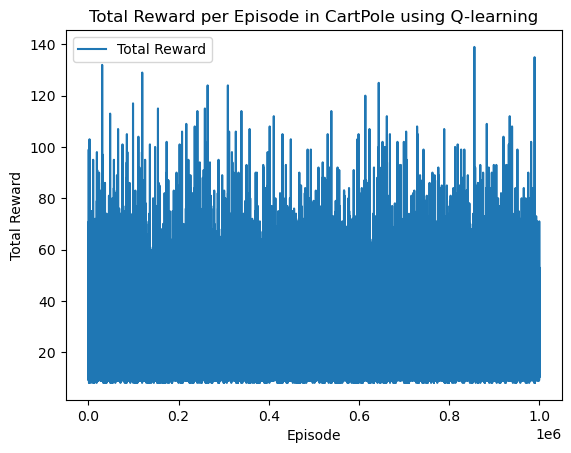

In [90]:
q_table_optimal = train_agent(number_episodes = 1000000, log=False)

In [ ]:
score = 0
for i in range(100):
    state = env.reset()[0]
    state = discretize_state(state, bins)
    score+=play(state, q_table_optimal, False)
print("Avr Score:", score/100)